# About the data

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# Project Goal
Identify fraudulent credit card transactions.

# Results
1. Distribution-based modeling reach a F1 score = 0.74

2. Trained Supervised ML (Random Forest) with SMOTE sampling technique improved F1 score from 0.82 to 0.85. 

3. Added the predicted probability feature from the distribution-based modeling, and got an F1 score of 0.83 using Random Forest (with SMOTE, improved to 0.84)

4. I also tried unsupervised algorithm isolation forest, which gives a F1 score = 0.36

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


# 1. Data Import

In [116]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
!ls "/content/drive/My Drive/fraudData"

creditcard.csv	imbalancedFraudDF.csv  IpAddress_to_Country.csv


In [118]:
creditcardDF = pd.read_csv('drive/My Drive/fraudData/creditcard.csv') 
creditcardDF.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The features are all numerical and anonymous, seems normalized

# 2. EDA

In [119]:
#Distribution of the label column
creditcardDF['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [120]:
print(creditcardDF['Class'].sum()/len(creditcardDF['Class'])) #<0.2 percent

0.001727485630620034


Less than 0.2% of fraudulent transactions. Highly imbalanced

In [121]:
creditcardDF.shape

(284807, 31)

In [122]:
#check missing value
creditcardDF.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [123]:
# check the unique values for each column
creditcardDF.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


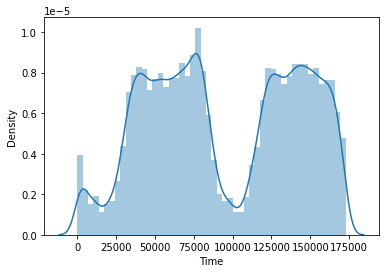

In [124]:
sns.distplot(creditcardDF['Time'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


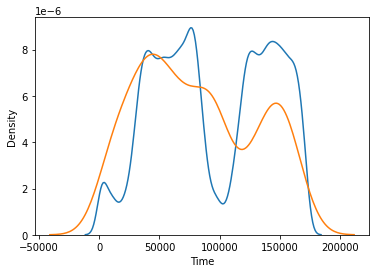

In [125]:
# density plot by class
sns.distplot(creditcardDF[creditcardDF['Class'] == 0]['Time'], hist = False, kde = True, label='class = 0')
sns.distplot(creditcardDF[creditcardDF['Class'] == 1]['Time'], hist = False, kde = True, label='class = 1')

# creditcardDF.groupby("Class").Time.plot(kind='kde',legend=True)
# sns.displot(data=creditcardDF, x='Time', hue='Class', kind='kde')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


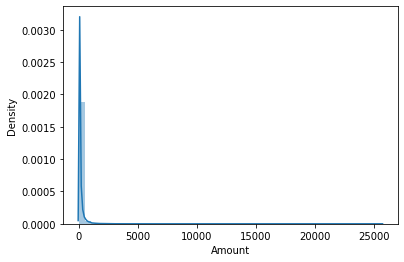

In [126]:
sns.distplot(creditcardDF['Amount'])

Class
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Amount, dtype: object

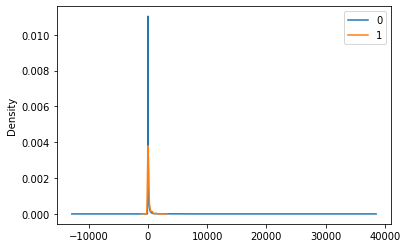

In [127]:
creditcardDF.groupby("Class").Amount.plot(kind='kde',legend=True)

In [128]:
# amount and time are quite skewed (not normal)
# do log tranformation to have a nicer range
creditcardDF['Amount'] = np.log(creditcardDF['Amount'] + 1)

creditcardDF['Time'] = np.log(creditcardDF['Time'] + 1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


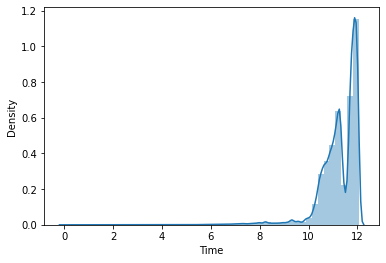

In [129]:
sns.distplot(creditcardDF['Time'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


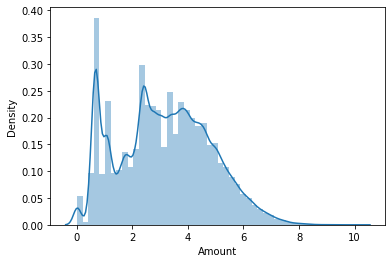

In [130]:
sns.distplot(creditcardDF['Amount'])

#3. Distribution-based Modeling

## Train, Validation, Test Split

- Train: 80% of 0 class
- Validation: 50% of 1 class + 10% of 0 class
- Test: 50% of 1 class + 10% of 0 class


In [131]:
normal = creditcardDF[creditcardDF['Class'] == 0]
anomaly = creditcardDF[creditcardDF['Class'] == 1]

# all normal/good
train, test = train_test_split(normal, test_size=0.2, random_state=0)

#all normal/good
normal_valid, normal_test = train_test_split(test, test_size=0.5, random_state=0)

#all anomaly/bad
anomaly_valid, anomaly_test = train_test_split(anomaly, test_size=0.5, random_state=0)

#include both good and bad
validation = pd.concat([normal_valid, anomaly_valid])

#include both good and bad
test = pd.concat([normal_test, anomaly_test])


print('validation: ',validation.shape)
print('test: ', test.shape)

#no need of label in train data, drop it
train = train.drop(columns = ['Class']).reset_index(drop= True)
print('train: ', train.shape)

validation:  (28677, 31)
test:  (28678, 31)
train:  (227452, 30)


In [132]:
# get a list of feature names, no label
featureNames = list(train.columns.values)

#feature df only, no label
valFeatures = validation[featureNames].reset_index(drop= True)
testFeatures = test[featureNames].reset_index(drop= True)

#label df only
valLabel = validation['Class']
testLabel = test['Class']


In [133]:
valFeatures.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,11.827043,-0.248023,1.259502,-0.993999,-1.587788,1.913462,-0.630270,1.958852,-0.659274,0.002373,0.718353,0.474332,0.297023,-0.025971,0.256813,-0.730278,-0.479395,-1.145347,0.234891,0.351396,0.396605,0.089915,0.896611,-0.367547,0.143515,-0.177558,0.025269,0.271419,-0.066416,0.920283
1,10.809566,-1.614505,-0.970137,1.730517,-1.715497,-0.869271,-0.171355,1.216768,-0.031314,0.992762,-2.191051,-1.019348,0.600947,0.821185,-0.477250,0.612733,-0.092783,-0.664174,0.643702,-0.047904,0.831753,0.408654,0.630537,0.382848,-0.110627,0.906539,-0.618206,-0.026364,0.104561,5.874931
2,11.340380,1.106176,0.148096,0.424489,1.282916,-0.080275,0.146526,-0.007108,0.114953,-0.004731,0.033642,1.200830,1.342878,0.018898,0.217944,-0.819673,-0.536572,-0.000444,-0.509860,-0.081917,-0.148073,-0.042488,0.071593,-0.085294,0.032780,0.637894,-0.331179,0.036130,0.007639,2.866193
3,11.321208,-1.791995,1.102738,0.324217,1.082267,-0.303348,-1.050303,0.066270,0.613586,-0.720545,-0.232754,-0.741686,0.317251,0.404740,0.810007,0.990986,-0.069383,0.096501,0.143086,0.447363,-0.285331,0.151935,0.514245,0.290932,0.403345,-0.064118,-0.318054,0.021940,0.013401,3.432373
4,11.956784,1.924286,0.324362,-0.734639,3.370481,0.783552,1.224944,-0.298881,0.291717,-0.790152,1.592072,-0.561561,-0.101690,-0.249445,0.233490,-1.160360,1.566431,-1.480919,0.594003,-0.903739,-0.227395,-0.022543,-0.115448,0.143200,-0.357497,-0.109288,-0.105516,-0.025440,-0.050761,2.572612


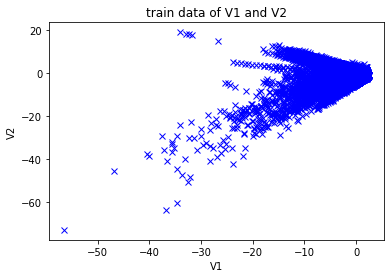

In [134]:
plt.figure()
plt.title("train data of V1 and V2")#may contain outliers
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(train.iloc[:, 1],train.iloc[:,2],"bx")
plt.show()

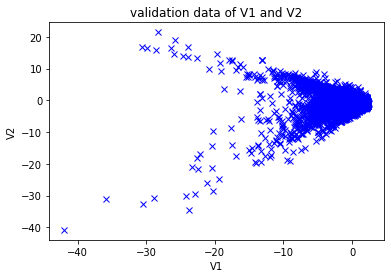

In [135]:
plt.figure()
plt.title("validation data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(validation.iloc[:, 1],validation.iloc[:,2],"bx")
plt.show()

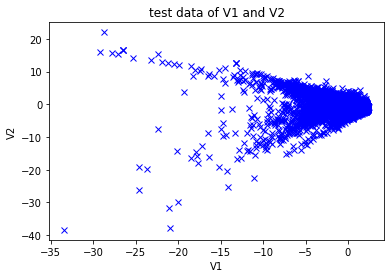

In [136]:
plt.figure()
plt.title("test data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(test.iloc[:, 1],test.iloc[:,2],"bx")
plt.show()

### Fit Multivariate Gaussian distribution
The multivariate normal, multinormal or Gaussian distribution is a generalization of the one-dimensional normal distribution to higher dimensions. Such a distribution is specified by its mean and covariance matrix. These parameters are analogous to the mean (average or “center”) and variance (standard deviation, or “width,” squared) of the one-dimensional normal distribution.

In [137]:
# def read_dataset(filePath, delimiter=','):
#     return genfromtxt(filePath, delimiter=delimiter)

#find mean and covaraince matrix parameter for each col/feature in df for the Gaussian distribution
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma


In [138]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html
#Return evenly spaced numbers over a specified interval.
np.linspace(1, 21,10, endpoint = False)

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.])

In [139]:
#step 1: model training 
mu, sigma = estimateGaussian(train)


In [140]:
print(np.mean(train.iloc[:,1]))
print(mu[1])

0.005246755420062154
0.005246755420062154


In [141]:
print(mu)
# print(sigma)

Time      11.252384
V1         0.005247
V2        -0.005416
V3         0.010293
V4        -0.008144
V5         0.004281
V6         0.001813
V7         0.010354
V8        -0.001103
V9         0.006351
V10        0.009573
V11       -0.007736
V12        0.009943
V13        0.001084
V14        0.010816
V15        0.001082
V16        0.007216
V17        0.012364
V18        0.003412
V19       -0.001811
V20       -0.001092
V21       -0.001302
V22       -0.000354
V23        0.000209
V24        0.000288
V25        0.000375
V26        0.000457
V27       -0.000509
V28       -0.000119
Amount     3.152259
dtype: float64


In [142]:
#generate the probability density function/curve/surface/model for multivariate_normal given mean and cov 
model = multivariate_normal(mean=mu, cov=sigma, allow_singular = True)#surface hat

In [143]:
pdfVal = model.pdf(valFeatures)
print(max(pdfVal))# the prob are too small, can not differentiate
print(min(pdfVal))

3.936022689247968e-12
0.0


In [144]:
#Log of the pdf first, then apply to features, to change the magnitude of prob
p_val = model.logpdf(valFeatures)
print(max(p_val))#
print(min(p_val))

-26.26085037221045
-7554.270217704667


In [145]:
p = model.logpdf(train)
print(p.shape)
print((p_val.shape))
print(p)

(227452,)
(28677,)
[-31.00401099 -43.63232557 -33.03230045 ... -30.36472744 -35.74472592
 -37.79165708]


In [146]:
print('range of p in validation :', min(p_val), max(p_val))

print('range of p in training :', min(p), max(p))

range of p in validation : -7554.270217704667 -26.26085037221045
range of p in training : -18323.67043953756 -25.96282892225995


### Find Threshold

In [147]:
scores = []
p_val = model.logpdf(valFeatures)#Log of the pdf

#generate all candidate threshold, epsilon
thresholds = np.linspace(min(p_val), max(p_val),200)

#step 2: CV to find optimal threshold: bestThreshold
for threshold in thresholds:
  y_pred = (p_val < threshold).astype(int)# list of 0 and 1
  #calculate recall, precision and f1 for each (truth, pred) pair, corresponding to that threshold
  scores.append([recall_score(valLabel, y_pred),
                 precision_score(valLabel, y_pred),
                 f1_score(valLabel, y_pred, average = "binary")])

scores = np.array(scores)

print(scores.shape)#each row is a pair of (recall, precision, f1) corresponding to a threshold

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(200, 3)


In [148]:
print(scores)

[[0.         0.         0.        ]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01

In [149]:
# find the best f1_score 
maxIndex = scores[...,2].ravel().argmax()
bestThreshold = thresholds[maxIndex]

print(maxIndex)
print(bestThreshold)

193
-253.2360071762041


### performance on test data

In [150]:
#step 3: prediction on test data
y_test_pred_raw = model.logpdf(testFeatures)
y_pred_test = y_test_pred_raw < bestThreshold

f1_score(testLabel, y_pred_test, average = "binary")

0.7401574803149606

In [151]:
#index of predicted outliers in test data
predoutliersTest = np.asarray(np.where(y_pred_test))

len(predoutliersTest[0])

262

In [152]:
predoutliersTest

array([[  248,   437,   605,  1007,  1353,  1451,  1462,  1546,  1988,
         2461,  3674,  3928,  4216,  4928,  5144,  5846,  5975,  6022,
         6682,  6706,  6858,  7017,  7138,  8267,  8452,  8611,  8677,
         8936,  8996,  9207,  9443,  9807,  9988, 10263, 10391, 10657,
        11224, 12205, 13539, 13935, 14050, 14573, 14579, 14802, 14869,
        15740, 16061, 16888, 17322, 17663, 19352, 19902, 20680, 20800,
        21748, 22366, 22552, 22859, 23217, 23456, 23742, 24639, 24819,
        25654, 25678, 26035, 27282, 27293, 27314, 27587, 27723, 28117,
        28178, 28396, 28432, 28433, 28434, 28435, 28436, 28437, 28438,
        28440, 28443, 28444, 28445, 28446, 28447, 28449, 28450, 28453,
        28454, 28455, 28456, 28457, 28458, 28459, 28460, 28461, 28462,
        28463, 28464, 28465, 28466, 28467, 28468, 28469, 28470, 28471,
        28472, 28473, 28475, 28479, 28480, 28481, 28482, 28483, 28484,
        28486, 28487, 28490, 28492, 28493, 28494, 28496, 28497, 28498,
      

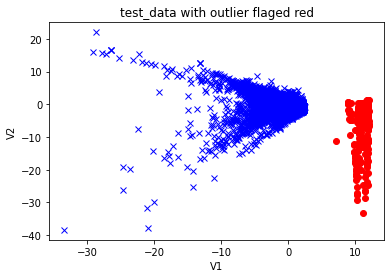

In [153]:
#outliers identified on test data feature column V1 V2
plt.figure()
plt.title("test_data with outlier flaged red")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(testFeatures.iloc[:, 1],testFeatures.iloc[:,2],"bx") #plot v1 v2 as blue cross
plt.plot(testFeatures.iloc[predoutliersTest[0],0],testFeatures.iloc[predoutliersTest[0],1],"ro")#re-plot the outliers as red dots
plt.show()

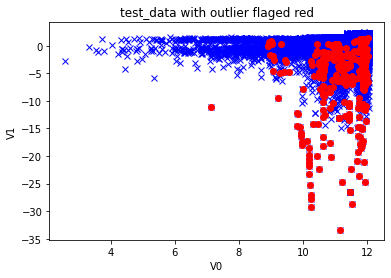

In [154]:
#outliers identified on test data feature column V0 V1
plt.figure()
plt.title("test_data with outlier flaged red")
plt.xlabel("V0")
plt.ylabel("V1")
plt.plot(testFeatures.iloc[:, 0],testFeatures.iloc[:,1],"bx") #plot v1 v2 as blue cross
plt.plot(testFeatures.iloc[predoutliersTest[0],0],testFeatures.iloc[predoutliersTest[0],1],"ro")#re-plot the outliers as red dots
plt.show()

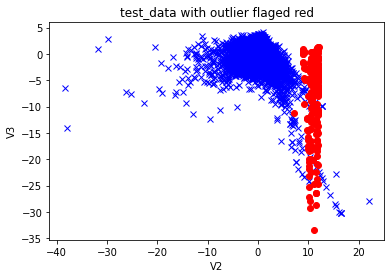

In [155]:
#outliers identified on test data feature column V2 V3
plt.figure()
plt.title("test_data with outlier flaged red")
plt.xlabel("V2")
plt.ylabel("V3")
plt.plot(testFeatures.iloc[:, 2],testFeatures.iloc[:,3],"bx")
plt.plot(testFeatures.iloc[predoutliersTest[0],0],testFeatures.iloc[predoutliersTest[0],1],"ro")
plt.show()

In [156]:
# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(testLabel, y_pred_test)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(testLabel, y_test_pred_raw)))
print("%s: %r" % ("f1_score is: ", f1_score(testLabel, y_pred_test )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(testLabel, y_pred_test)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0


accuracy_score is: : 0.9953971685612665
roc_auc_score is: : 0.03898289914947546
f1_score is: : 0.7401574803149606
confusion_matrix is: 
        pred_0  pred_1
true_0   28358      74
true_1      58     188
recall = 0.7642276422764228
precision = 0.7175572519083969


# 4. Supervised ML

In [157]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [158]:
y = creditcardDF['Class']
X = creditcardDF.drop(['Class'], axis=1)

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (227845, 30)
y_train.shape: (227845,)
X_test.shape: (56962, 30)


### simple logistic regression

In [159]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

# predict on test
y_pred=logreg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [160]:
cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0
print(classification_report(y_test,y_pred))

        pred_0  pred_1
true_0   56854      10
true_1      36      62
recall = 0.6326530612244898
precision = 0.8611111111111112
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.63      0.73        98

    accuracy                           1.00     56962
   macro avg       0.93      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



### simple random forest

In [161]:
classifier_RF = RandomForestClassifier(random_state=0)

classifier_RF.fit(X_train, y_train)

# predict class labels 0/1 for the test set
predicted = classifier_RF.predict(X_test)

# generate class probabilities
probs = classifier_RF.predict_proba(X_test)

# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0
print(classification_report(y_test,predicted))

accuracy_score is: : 0.9994557775359011
roc_auc_score is: : 0.9319579548195192
f1_score is: : 0.8187134502923976
confusion_matrix is: 
        pred_0  pred_1
true_0   56861       3
true_1      28      70
recall = 0.7142857142857143
precision = 0.958904109589041
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.71      0.82        98

    accuracy                           1.00     56962
   macro avg       0.98      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962



### SMOTE Sampling

In [162]:
smote = SMOTE(random_state=12)
x_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

unique, counts = np.unique(y_train_sm, return_counts=True)

print(np.asarray((unique, counts)).T)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[     0 227451]
 [     1 227451]]


In [163]:
#RF on smoted training data
classifier_RF_sm = RandomForestClassifier(random_state=0)

classifier_RF_sm.fit(x_train_sm, y_train_sm)

# predict class labels for the test set
predicted_sm = classifier_RF_sm.predict(X_test)

# generate class probabilities
probs_sm = classifier_RF_sm.predict_proba(X_test)


# generate evaluation metrics
print("%s: %r" % ("accuracy_score_sm is: ", accuracy_score(y_test, predicted_sm)))
print("%s: %r" % ("roc_auc_score_sm is: ", roc_auc_score(y_test, probs_sm[:, 1])))
print("%s: %r" % ("f1_score_sm is: ", f1_score(y_test, predicted_sm )))#string to int

print ("confusion_matrix_sm is: ")
cm_sm = confusion_matrix(y_test, predicted_sm)
cmDF = pd.DataFrame(cm_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall or sens_sm =',float(cm_sm[1,1])/(cm_sm[1,0]+cm_sm[1,1]))
print('precision_sm =', float(cm_sm[1,1])/(cm_sm[1,1] + cm_sm[0,1]))
print(classification_report(y_test,predicted_sm))
#different AUC??

accuracy_score_sm is: : 0.9995259997893332
roc_auc_score_sm is: : 0.9737786469399239
f1_score_sm is: : 0.850828729281768
confusion_matrix_sm is: 
        pred_0  pred_1
true_0   56858       6
true_1      21      77
recall or sens_sm = 0.7857142857142857
precision_sm = 0.927710843373494
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.79      0.85        98

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [164]:
print(classification_report(y_test,predicted_sm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.79      0.85        98

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



SMOTE improved the result quite a bit

# 5. Parameter tuning by GridSearchCV

In [165]:
# Eval metrics to be calculated for each combination of parameters and cv, they are all calculated(by scoring), but not necessarily used to pick the optimal(by refit)
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)
    
}

In [166]:
def grid_search_wrapper(model, parameters, refit_score='f1_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """

    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    
    print("\t%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("\t%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int

    print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search



### Optimizing on f1_score on RF

In [167]:
parameters = {        
'max_depth': [None, 5, 15],
'n_estimators' :  [10,150],
'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}

clf = RandomForestClassifier(random_state=0)

In [168]:
grid_search_rf_f1 = grid_search_wrapper(clf, parameters, refit_score='f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 1}, 'max_depth': None, 'n_estimators': 150}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   56861       3
true_1      27      71
	roc_auc_score is: : 0.9365116949283934
	f1_score is: : 0.8255813953488371
recall =  0.7244897959183674
precision =  0.9594594594594594


In [169]:
best_rf_model_f1 = grid_search_rf_f1.best_estimator_
best_rf_model_f1

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [170]:
results_f1 = pd.DataFrame(grid_search_rf_f1.cv_results_)
results_sortf1 = results_f1.sort_values(by='mean_test_f1_score', ascending=False)
results_sortf1[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()



,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
7,0.943,0.789,0.859,1.000,1.000,1.000,None,"{0: 1, 1: 1}",150
11,0.940,0.789,0.858,1.000,0.897,0.946,15,"{0: 1, 1: 1}",150
13,0.961,0.774,0.857,1.000,1.000,1.000,None,"{0: 1, 1: 100}",150
17,0.952,0.779,0.856,0.997,0.999,0.998,15,"{0: 1, 1: 100}",150
1,0.935,0.789,0.855,1.000,1.000,1.000,None,"{0: 1, 1: 0.2}",150


In [171]:
#Var Importance
pd.DataFrame(best_rf_model_f1.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)



,importance
V17,0.139025
V12,0.131811
V14,0.115926
V10,0.098128
V11,0.077067
V16,0.074779
V9,0.037764
V18,0.036124
V7,0.026054
V4,0.023490


# 6. Additional Feature Engineering
Use the output prob from distribution-based model as an additional input feature of the supervised learning model, and see if it improved the model performance

In [172]:
# prediction on all data
allFeatures = creditcardDF[featureNames].reset_index(drop= True)
y_pred_raw = model.logpdf(allFeatures)
print(len(y_pred_raw))
y_pred_raw

284807


array([-151.39263249, -156.61141129, -150.16963606, ...,  -34.79543661,
        -40.23622376,  -29.87168758])

In [173]:
# convert to values between 0 and 1
y_pred_raw = np.exp(y_pred_raw)
print(min(y_pred_raw))
print(max(y_pred_raw))

0.0
5.302573101892494e-12


In [174]:
print(len(y_pred_raw))

284807


In [175]:
df = creditcardDF.copy()
print(df.shape)

(284807, 31)


In [176]:
df['oup_prob'] = y_pred_raw

In [177]:
y = df['Class']
X = df.drop(['Class'], axis=1)

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (227845, 31)
y_train.shape: (227845,)
X_test.shape: (56962, 31)


In [178]:
classifier_RF = RandomForestClassifier(random_state=0)

classifier_RF.fit(X_train, y_train)

# predict class labels 0/1 for the test set
predicted = classifier_RF.predict(X_test)

# generate class probabilities
probs = classifier_RF.predict_proba(X_test)

# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0
print(classification_report(y_test,predicted))

accuracy_score is: : 0.9994733330992591
roc_auc_score is: : 0.9267924794425368
f1_score is: : 0.8275862068965517
confusion_matrix is: 
        pred_0  pred_1
true_0   56860       4
true_1      26      72
recall = 0.7346938775510204
precision = 0.9473684210526315
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.73      0.83        98

    accuracy                           1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [179]:
smote = SMOTE(random_state=12)
x_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

unique, counts = np.unique(y_train_sm, return_counts=True)

print(np.asarray((unique, counts)).T)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[     0 227451]
 [     1 227451]]


In [180]:
#RF on smoted training data
classifier_RF_sm = RandomForestClassifier(random_state=0)

classifier_RF_sm.fit(x_train_sm, y_train_sm)

# predict class labels for the test set
predicted_sm = classifier_RF_sm.predict(X_test)

# generate class probabilities
probs_sm = classifier_RF_sm.predict_proba(X_test)


# generate evaluation metrics
print("%s: %r" % ("accuracy_score_sm is: ", accuracy_score(y_test, predicted_sm)))
print("%s: %r" % ("roc_auc_score_sm is: ", roc_auc_score(y_test, probs_sm[:, 1])))
print("%s: %r" % ("f1_score_sm is: ", f1_score(y_test, predicted_sm )))#string to int

print ("confusion_matrix_sm is: ")
cm_sm = confusion_matrix(y_test, predicted_sm)
cmDF = pd.DataFrame(cm_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall or sens_sm =',float(cm_sm[1,1])/(cm_sm[1,0]+cm_sm[1,1]))
print('precision_sm =', float(cm_sm[1,1])/(cm_sm[1,1] + cm_sm[0,1]))
print(classification_report(y_test,predicted_sm))


accuracy_score_sm is: : 0.9995084442259752
roc_auc_score_sm is: : 0.952209729910535
f1_score_sm is: : 0.8444444444444446
confusion_matrix_sm is: 
        pred_0  pred_1
true_0   56858       6
true_1      22      76
recall or sens_sm = 0.7755102040816326
precision_sm = 0.926829268292683
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.78      0.84        98

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



# 7. Try Unupervised Machine Learning
# Isolation Forest Algorithm

In [181]:
from sklearn.ensemble import IsolationForest

In [182]:
#include all data except labels
data = creditcardDF[featureNames].values
print(type(data))

<class 'numpy.ndarray'>


In [183]:
outlier_fraction = creditcardDF['Class'].sum()/len(creditcardDF['Class'])
outlier_fraction

0.001727485630620034

In [184]:
isolation_forest = IsolationForest(n_estimators=100, 
                                   max_samples=len(data), 
                                   contamination=outlier_fraction,
                                   random_state=0)

In [185]:
# fit the model
isolation_forest.fit(data)

IsolationForest(behaviour='deprecated', bootstrap=False,
                contamination=0.001727485630620034, max_features=1.0,
                max_samples=284807, n_estimators=100, n_jobs=None,
                random_state=0, verbose=0, warm_start=False)

In [186]:
# predict label 1 for normal and -1 for abnormal
y_pred = isolation_forest.predict(data)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [187]:
# get anomaly score for each data point
scores_prediction = isolation_forest.decision_function(data)
scores_prediction

array([0.08257958, 0.08952257, 0.06338475, ..., 0.18907985, 0.1729923 ,
       0.1932515 ])

In [188]:
(y_pred<0).mean()  # contamination fraction determines this

0.001727485630620034

In [189]:
# get index of predicted abnormals
ab_index = np.where(y_pred<0)


In [190]:
len(ab_index[0])

492

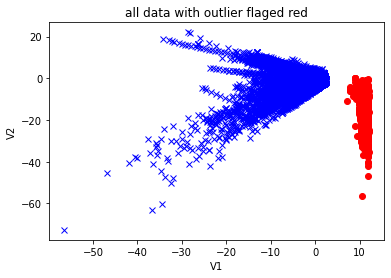

In [191]:
#outliers identified on all data feature column V1 V2
plt.figure()
plt.title("all data with outlier flaged red")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(data[:, 1],data[:,2],"bx") #plot v1 v2 as blue cross
plt.plot(data[ab_index,0],data[ab_index,1],"ro")#re-plot the outliers as red dots
plt.show()

In [192]:
trueLabel = creditcardDF['Class']

In [193]:
 #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [194]:
 # generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(trueLabel, y_pred)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(trueLabel, scores_prediction)))
print("%s: %r" % ("f1_score is: ", f1_score(trueLabel, y_pred )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(trueLabel, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0


accuracy_score is: : 0.9977879757168889
roc_auc_score is: : 0.042613125628293023
f1_score is: : 0.3597560975609756
confusion_matrix is: 
        pred_0  pred_1
true_0  284000     315
true_1     315     177
recall = 0.3597560975609756
precision = 0.3597560975609756


In [195]:
from sklearn.metrics import classification_report,accuracy_score

# # Run Classification Metrics
print("Classification Report :")
print(classification_report(trueLabel,y_pred))

Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.36      0.36      0.36       492

    accuracy                           1.00    284807
   macro avg       0.68      0.68      0.68    284807
weighted avg       1.00      1.00      1.00    284807



In [196]:
#note we can apply supervised learning on this data too, but performance may be different, 
#can try use the output prob as an additional input feature of the supervised learning model, and see if it improved the model perf